# San Francisco Housing Cost Analysis

In this assignment, you will perform fundamental analysis for the San Francisco housing market to allow potential real estate investors to choose rental investment properties.

In [215]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')

In [216]:
# Read the Mapbox API key
load_dotenv("../Resources/.env")
map_box_api = os.getenv("mapbox")

## Load Data

In [217]:
# Read the census data into a Pandas DataFrame
file_path = Path("../Resources/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

- - - 

## Housing Units Per Year

In this section, you will calculate the number of housing units per year and visualize the results as a bar chart using the Pandas plot function.

**Hint:** Use the Pandas `groupby` function.

**Optional challenge:** Use the min, max, and std to scale the y limits of the chart.



In [218]:
# Calculate the mean number of housing units per year (hint: use groupby) 
mean_units_by_year = sfo_data["housing_units"].groupby("year").mean()
# Save the dataframe as a csv file
mean_units_by_year.to_csv(r'../Resources/mean_housing_units_by_year.csv', index = False)

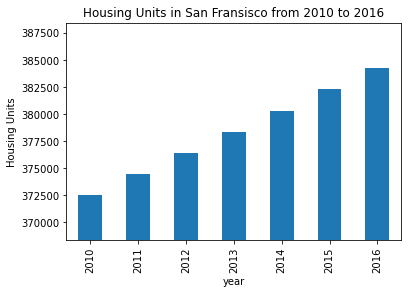

In [219]:
# Use the Pandas plot function to plot the average housing units per year.
# Note: You will need to manually adjust the y limit of the chart using the min and max values from above.
std = mean_units_by_year.std()
sf_housing_plot = mean_units_by_year.plot(kind='bar',
                                          title='Housing Units in San Fransisco from 2010 to 2016',
                                          ylim=[(min(mean_units_by_year) - (std)), (max(mean_units_by_year) + (std))]
                                         ).set_ylabel("Housing Units")

- - - 

## Average Housing Costs in San Francisco Per Year

In this section, you will calculate the average monthly rent and the average price per square foot for each year. An investor may wish to better understand the sales price of the rental property over time. For example, a customer will want to know if they should expect an increase or decrease in the property value over time so they can determine how long to hold the rental property.  Plot the results as two line charts.

**Optional challenge:** Plot each line chart in a different color.

In [220]:
# Calculate the average sale price per square foot and average gross rent
price_sqr_foot_data = sfo_data["sale_price_sqr_foot"].groupby("year").mean()
gross_rent_data = sfo_data["gross_rent"].groupby("year").mean()
price_data_df = pd.concat([price_sqr_foot_data, gross_rent_data], axis=1, join='inner')

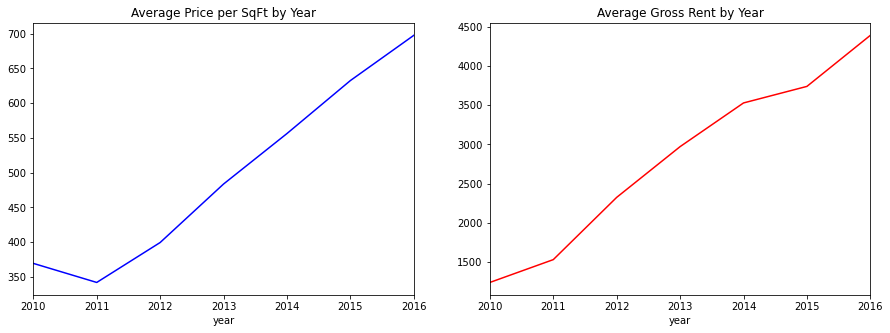

In [221]:
# Create two line charts, one to plot the average sale price per square foot and another for average montly rent
fig, axs = plt.subplots(1,2)
# Line chart for average sale price per square foot
avg_price_sqft_plot = price_data_df['sale_price_sqr_foot'].plot(title='Average Price per SqFt by Year', 
                                                    y='Price per Sqft', x='Year', color='blue', ax=axs[0], figsize=(15,5))
# Line chart for average montly rent
avg_gross_rent_plot = price_data_df['gross_rent'].plot(title="Average Gross Rent by Year", 
                                                    y='Gross Rent', x='Year', color = 'red', ax=axs[1])


- - - 

## Average Prices by Neighborhood

In this section, you will use hvplot to create two interactive visulizations of average prices with a dropdown selector for the neighborhood. The first visualization will be a line plot showing the trend of average price per square foot over time for each neighborhood.  The second will be a line plot showing the trend of average montly rent over time for each neighborhood.

**Hint:** It will be easier to create a new DataFrame from grouping the data and calculating the mean prices for each year and neighborhood

In [222]:
# Group by year and neighborhood and then create a new dataframe of the mean values
sfo_df = sfo_data.reset_index().groupby(['year', 'neighborhood'], as_index=False)
averages_sfo_df = sfo_df.mean()

In [223]:
# Use hvplot to create an interactive line chart of the average price per sq ft.
# The plot should have a dropdown selector for the neighborhood
avg_price_neighborhood = averages_sfo_df.hvplot.line(x='year', y='sale_price_sqr_foot', groupby='neighborhood',xlabel='Year',
                           ylabel="Price per Sqaure Foot")
avg_price_neighborhood

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [224]:
# Use hvplot to create an interactive line chart of the average monthly rent.
# The plot should have a dropdown selector for the neighborhood
avg_gross_rent_neighborhood = averages_sfo_df.hvplot.line(x='year', y='gross_rent', groupby='neighborhood',
                           xlabel='Year',
                           ylabel="Gross Rent")
avg_gross_rent_neighborhood

:DynamicMap   [neighborhood]
   :Curve   [year]   (gross_rent)

## The Top 10 Most Expensive Neighborhoods

In this section, you will need to calculate the mean sale price per square foot for each neighborhood and then sort the values to obtain the top 10 most expensive neighborhoods on average. Plot the results as a bar chart.

In [225]:
top_neighborhoods = sfo_data.reset_index().groupby(['neighborhood', 'sale_price_sqr_foot'], as_index=False).mean()

In [226]:
top_neighborhoods_df = (
    top_neighborhoods
    .groupby("neighborhood")
    .mean()
    .sort_values("sale_price_sqr_foot", ascending=False)
    .reset_index()
)
top_neighborhoods_df = top_neighborhoods_df[:10]

In [227]:
# Plotting the data from the top 10 expensive neighborhoods
top_neighborhoods_df.hvplot.bar(title='Top 10 Expensive Neighborhoods in SFO',
                            x='neighborhood',
                            y='sale_price_sqr_foot',
                            rot=60,
                            frame_height=350,
                               frame_width=700,
                               xlabel='Neighborhood',
                               ylabel="Average Price per SqFt",
                               ylim=(550, 950))


:Bars   [neighborhood]   (sale_price_sqr_foot)

- - - 

## Comparing cost to purchase versus rental income

In this section, you will use `hvplot` to create an interactive visualization with a dropdown selector for the neighborhood. This visualization will feature a side-by-side comparison of average price per square foot versus average montly rent by year.  

**Hint:** Use the `hvplot` parameter, `groupby`, to create a dropdown selector for the neighborhood.

In [228]:
# Fetch the previously generated DataFrame that was grouped by year and neighborhood
sfo_df_year_hood = sfo_data.reset_index().groupby(['year', 'neighborhood'], as_index=False)

In [229]:
# Plotting the data 
sfo_data.hvplot.bar(
                    y=('sale_price_sqr_foot', 'gross_rent'),
                    x='year',
                    groupby='neighborhood',
                    rot=70,
                    xlabel='Year',
                    ylabel='Price',
                    legend='top',
                    responsive=True,
                    frame_height=300,
                    )

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

- - - 

## Neighborhood Map

In this section, you will read in neighborhoods location data and build an interactive map with the average house value per neighborhood. Use a `scatter_mapbox` from Plotly express to create the visualization. Remember, you will need your Mapbox API key for this.

### Load Location Data

In [230]:
# Load neighborhoods coordinates data
px.set_mapbox_access_token(map_box_api)

coordinates_data = pd.read_csv(Path("../Resources/neighborhoods_coordinates.csv"))

### Data Preparation

You will need to join the location data with the mean values per neighborhood.

1. Calculate the mean values for each neighborhood.

2. Join the average values with the neighborhood locations.

In [231]:
# Calculate the mean values for each neighborhood
mean_data = sfo_data.groupby('neighborhood', as_index=False).mean()

In [232]:
# Join the average values with the neighborhood locations
average_values_by_location = pd.concat([mean_data, coordinates_data], axis=1)

### Mapbox Visualization

Plot the average values per neighborhood using a Plotly express `scatter_mapbox` visualization.

In [233]:
# Create a scatter mapbox to analyze neighborhood info
neighborhood_data_plot = px.scatter_mapbox(
                            average_values_by_location,
                            lat='Lat',
                            lon='Lon',
                            color='gross_rent',
                            size='sale_price_sqr_foot',
                            title="Average Sale Price per Square Foot and Gross Rent in San Fransisco",
                            zoom=10,
                            width=1000,
                            hover_name='neighborhood',
                            hover_data={'housing_units': True, 'Lat':False, 'Lon':False, 'sale_price_sqr_foot':':.2f',
                                       'gross_rent':':.2f'},
                            labels={
                                'sale_price_sqr_foot': 'Price per SqFT',
                                'gross_rent': 'Gross Rent',
                                'housing_units': 'Housing Units'}
                                )

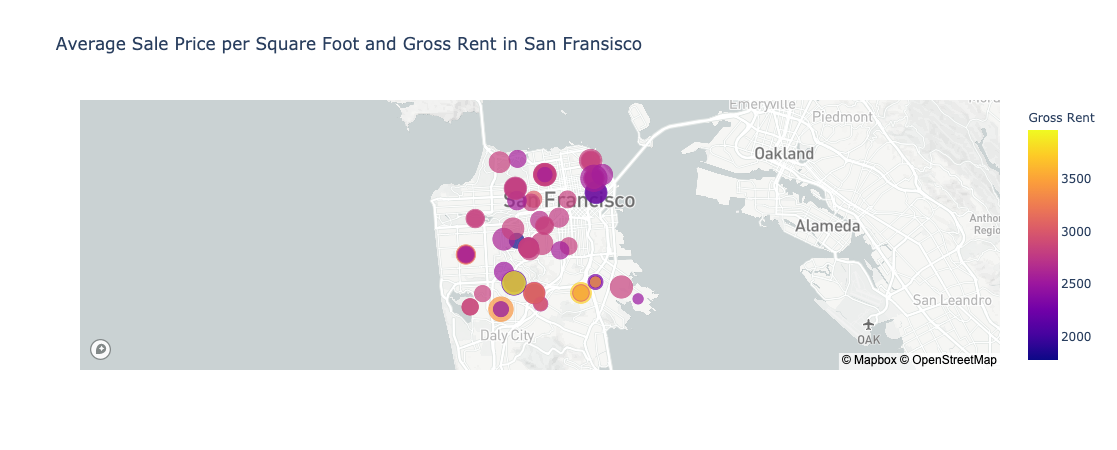

In [244]:
neighborhood_data_plot

- - -

## Cost Analysis - Optional Challenge

In this section, you will use Plotly express to create visualizations that investors can use to interactively filter and explore various factors related to the house value of the San Francisco's neighborhoods. 

### Create a DataFrame showing the most expensive neighborhoods in San Francisco by year

In [235]:
# Fetch the data from all expensive neighborhoods per year.
df_expensive_neighborhoods_per_year = mean_data[mean_data["neighborhood"].isin(top_neighborhoods_df["neighborhood"])]

### Create a parallel coordinates plot and parallel categories plot of most expensive neighborhoods in San Francisco per year


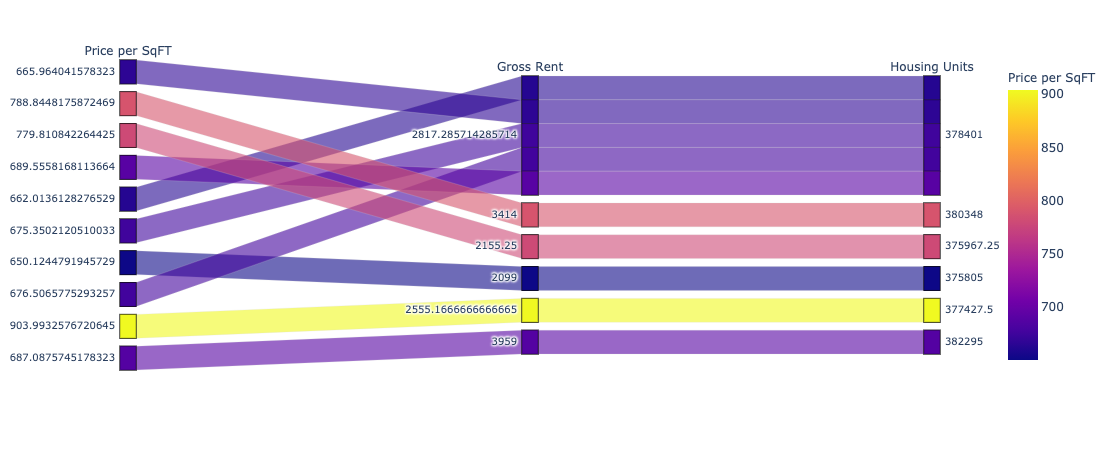

In [236]:
# Parallel Categories Plot
expensive_categories_plot = px.parallel_categories(
                            df_expensive_neighborhoods_per_year,
                            color='sale_price_sqr_foot',
                            dimensions=['sale_price_sqr_foot', 'gross_rent', 'housing_units'],
                            labels={
                                'sale_price_sqr_foot': 'Price per SqFT',
                                'gross_rent': 'Gross Rent',
                                'housing_units': 'Housing Units'},
                                )
expensive_categories_plot

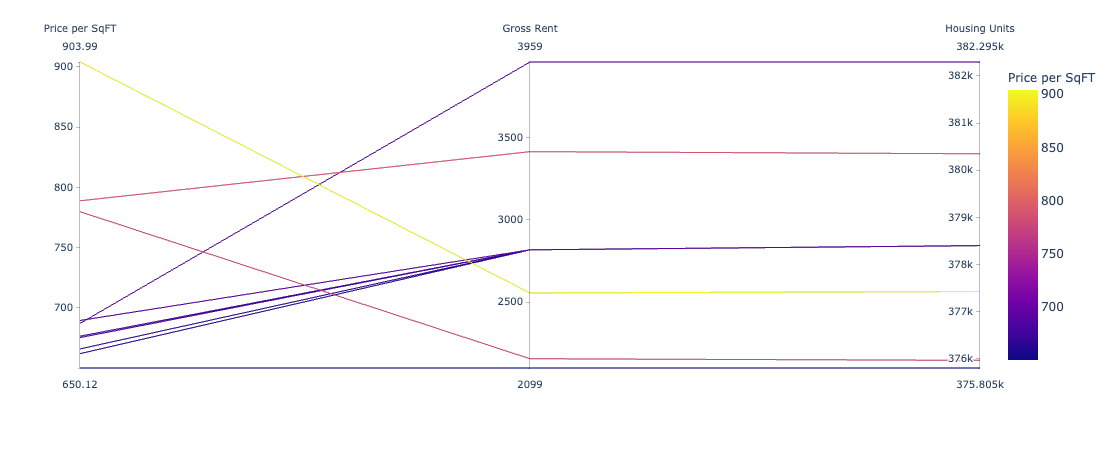

In [237]:
# Parallel Coordinates Plot
expensive_coordinates_plot = px.parallel_coordinates(
                            df_expensive_neighborhoods_per_year,
                            color='sale_price_sqr_foot',
                            dimensions=['sale_price_sqr_foot', 'gross_rent', 'housing_units'],
                            labels={
                                'sale_price_sqr_foot': 'Price per SqFT',
                                'gross_rent': 'Gross Rent',
                                'housing_units': 'Housing Units'},
                                )
expensive_coordinates_plot

### Create a sunburst chart to conduct a costs analysis of most expensive neighborhoods in San Francisco per year

In [238]:
sfo_df_sunburst = sfo_data.reset_index()

In [239]:
sfo_df_sunburst = pd.DataFrame(sfo_df_sunburst).sort_values(['year', 'sale_price_sqr_foot'], ascending=False)

In [240]:
#Pulling the Top 10 most expensive per year.
sfo_df_sunburst_2016 = sfo_df_sunburst[sfo_df_sunburst['year'] == 2016][:10]
sfo_df_sunburst_2015 = sfo_df_sunburst[sfo_df_sunburst['year'] == 2015][:10]
sfo_df_sunburst_2014 = sfo_df_sunburst[sfo_df_sunburst['year'] == 2014][:10]
sfo_df_sunburst_2013 = sfo_df_sunburst[sfo_df_sunburst['year'] == 2013][:10]
sfo_df_sunburst_2012 = sfo_df_sunburst[sfo_df_sunburst['year'] == 2012][:10]
sfo_df_sunburst_2011 = sfo_df_sunburst[sfo_df_sunburst['year'] == 2011][:10]
sfo_df_sunburst_2010 = sfo_df_sunburst[sfo_df_sunburst['year'] == 2010][:10]
frames = [sfo_df_sunburst_2016, sfo_df_sunburst_2015, sfo_df_sunburst_2014, sfo_df_sunburst_2013, sfo_df_sunburst_2012, sfo_df_sunburst_2011, sfo_df_sunburst_2010]
top_10_by_year = pd.concat(frames)

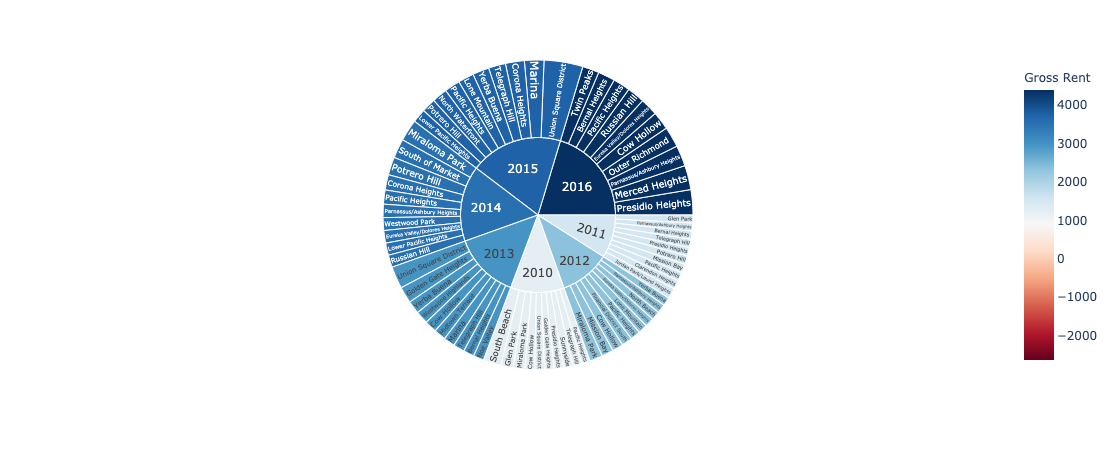

In [241]:
# Sunburst Plot
sunburst_plot = px.sunburst(
                            top_10_by_year,
                            path=['year', 'neighborhood'],
                            values='sale_price_sqr_foot',
                            color='gross_rent',
                            color_continuous_scale='RdBu',
                            color_continuous_midpoint=np.average(top_10_by_year['sale_price_sqr_foot'], 
                            weights=top_10_by_year['gross_rent']),
                            hover_name='neighborhood',
                            hover_data={'housing_units': True, 'sale_price_sqr_foot':':.2f',
                                       'gross_rent':':.2f'},
                            labels={
                                'sale_price_sqr_foot': 'Price per SqFT',
                                'gross_rent': 'Gross Rent',
                                'parent': 'Year'})
sunburst_plot